# Model Evaluation
## Best ML vs Best DL
### Evaluation & Visualization
### Models
 - Best ML: LightGBM
 - Best DL: Seq2Seq

In [1]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git


Cloning into 'Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform'...
remote: Enumerating objects: 317, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 317 (delta 51), reused 33 (delta 6), pack-reused 216 (from 1)
Receiving objects: 100% (317/317), 41.70 MiB | 15.97 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Filtering content: 100% (22/22), 348.58 MiB | 14.93 MiB/s, done.


In [2]:
# Import Libraries
import os, gc, json, joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# Set Project Root
os.chdir('/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform')
print("Current Directory: ", os.getcwd())

Current Directory:  /content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform


In [4]:
MODEL_PATH = Path('models')
REPORT_PATH = Path('data/reports')
REPORT_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
# Import Original Data
train = pd.read_parquet("data/features/train_features.parquet")

train["date"] = pd.to_datetime(train["date"])
train = train.sort_values(["store_nbr", "family", "date"]).reset_index(drop=True)



In [6]:

# Drop lag NaNs
lag_cols = [c for c in train.columns if "lag" in c or "roll" in c]
train = train.dropna(subset=lag_cols).reset_index(drop=True)



In [7]:
# Memory Optimization (reduce memory usage)
def reduce_mem_usage(df, ):
  for col in df.columns:
    if df[col].dtype == "float64":
      df[col] = df[col].astype("float32")
    elif df[col].dtype == "int64":
      df[col] = df[col].astype("int32")
  return df

train = reduce_mem_usage(train)
gc.collect()

0

# Prediction on ML(LightGBM) Model

In [8]:
# Recreate Features
DROP_COLS = ["id", "date", "sales", "sales_log"]
TARGET = "sales_log"

FEATURES = [c for c in train.columns if c not in DROP_COLS]

X_full = train[FEATURES]
y_full = train[TARGET]


In [9]:
# Categorical Features
CAT_COLS = [
    'family',
    'city',
    'state',
    'store_type',
    'holiday_type',
    'locale',
    'locale_name',
    'description'
]

for col in CAT_COLS:
    X_full[col] = X_full[col].astype("category")


In [10]:
import lightgbm as lgb

lgb_model = lgb.Booster(
    model_file="models/lightgbm/baseline_lightgbm.txt"
)

y_pred_lgb_log = lgb_model.predict(
    X_full,
    num_iteration=lgb_model.best_iteration
)

y_true_ml = np.expm1(y_full.values)
y_pred_ml= np.expm1(y_pred_lgb_log)


# Prediction on DL(Seq2Seq) Model

In [11]:
# Load DL Features map and scaler
import json, joblib

with open("models/dl_feature&Scaler/dl_feature_map.json", "r") as f:
    feature_map = json.load(f)

NUMERIC_FEATURES = feature_map["numeric_features"]
CATEGORICAL_FEATURES = feature_map["categorical_features"]
DL_FEATURES = feature_map["dl_features_order"]
category_maps = feature_map["category_maps"]
WINDOW_SIZE = feature_map["window_size"]

scaler = joblib.load("models/seq2seq_model/scaler.pkl")



In [12]:
# Encode Categories
df = train.copy()

def encode_categories(df, maps):
    df = df.copy()
    for col, mp in maps.items():
        df[col] = df[col].astype(str).map(mp).fillna(0).astype("int32")
    return df

df = encode_categories(df, category_maps)
df[NUMERIC_FEATURES] = scaler.transform(df[NUMERIC_FEATURES])


In [13]:
# Sliding Window Function
def sliding_window_generator(
    df,
    window_size,
    horizon,
    feature_cols,
    target_col,
    batch_size=256,
):
    X_batch, y_batch = [], []

    for _, gdf in df.groupby(["store_nbr", "family"]):
        gdf = gdf.sort_values("date")

        X = gdf[feature_cols].values.astype("float32")
        y = gdf[target_col].values.astype("float32")

        if len(gdf) < window_size + horizon:
            continue

        for i in range(len(gdf) - window_size - horizon + 1):
            X_batch.append(X[i:i+window_size])
            y_batch.append(y[i+window_size+horizon-1])

            if len(X_batch) == batch_size:
                yield np.array(X_batch), np.array(y_batch)
                X_batch, y_batch = [], []

    if X_batch:
        yield np.array(X_batch), np.array(y_batch)

## tf.data Dataset Wrapper
WINDOW_SIZE = 28
HORIZON = 1
TARGET = "sales_log"
BATCH_SIZE = 256

def make_dataset(df, shuffle=False):
    ds = tf.data.Dataset.from_generator(
        lambda: sliding_window_generator(
            df, WINDOW_SIZE, HORIZON, DL_FEATURES, TARGET, BATCH_SIZE
        ),
        output_signature=(
            tf.TensorSpec(
                shape=(None, WINDOW_SIZE, len(DL_FEATURES)),
                dtype=tf.float32
            ),
            tf.TensorSpec(shape=(None,), dtype=tf.float32),
        ),
    )
    if shuffle:
        ds = ds.shuffle(1024)
    return ds.prefetch(tf.data.AUTOTUNE)





In [14]:
full_dl_ds = make_dataset(df, shuffle=False)

In [15]:
# Adapt Seq2Seq Input
NUM_NUMERIC = len(NUMERIC_FEATURES)
NUM_CATEGORICAL = len(CATEGORICAL_FEATURES)

def adapt_batch(X_batch):
    X_num = X_batch[:, :, :NUM_NUMERIC]

    X_cat = [
        X_batch[:, :, NUM_NUMERIC + i].astype("int32")
        for i in range(NUM_CATEGORICAL)
    ]

    # Decoder input (teacher forcing placeholder)
    y_dec = np.zeros((X_batch.shape[0], 1, 1), dtype="float32")

    return [X_num] + X_cat + [y_dec]


In [16]:
# Load Seq2Seq Model
def rmsle_tf(y_true, y_pred):
    y_true = tf.exp(y_true)
    y_pred = tf.exp(y_pred)
    return tf.sqrt(
        tf.reduce_mean(
            tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))
        )
    )

seq2seq_model = tf.keras.models.load_model(
    MODEL_PATH / 'seq2seq_model' / 'seq2seq_model.keras',
    custom_objects={'rmsle_tf': rmsle_tf}
)

In [17]:
# Prediction on DL Dataset
y_true_all = []
y_pred_all = []

for X_batch, y_batch in full_dl_ds:
    X_batch = X_batch.numpy()
    y_batch = y_batch.numpy()

    inputs = adapt_batch(X_batch)

    preds = seq2seq_model.predict(
        inputs,
        batch_size=len(y_batch),
        verbose=0
    ).reshape(-1)

    y_true_all.append(y_batch)
    y_pred_all.append(preds)


In [18]:
# Concatenate all
y_true_dl_log = np.concatenate(y_true_all)
y_pred_dl_log = np.concatenate(y_pred_all)

# Back to Original Scale
y_true_dl = np.expm1(y_true_dl_log)
y_pred_dl = np.expm1(y_pred_dl_log)


# Evaluation Metrics

In [19]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(
        mean_squared_log_error(y_true, np.maximum(y_pred, 0))
    )

metrics = {
    "LightGBM": {
        "RMSLE": rmsle(y_true_ml, y_pred_ml),
        "MAE": mean_absolute_error(y_true_ml, y_pred_ml),
    },
    "Seq2Seq": {
        "RMSLE": rmsle(y_true_dl, y_pred_dl),
        "MAE": mean_absolute_error(y_true_dl, y_pred_dl),
    }
}

metrics_df = pd.DataFrame(metrics).T
metrics_df

,RMSLE,MAE
LightGBM,0.346664,40.644338
Seq2Seq,0.515767,85.346565


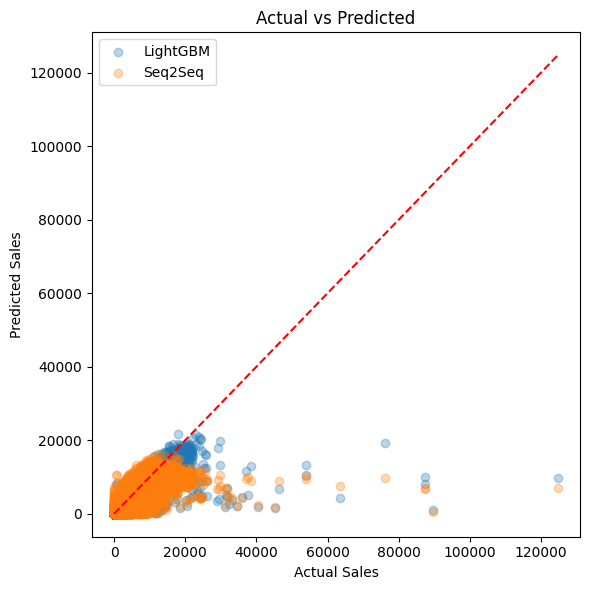

In [20]:
# Visualization Actual Vs Predicted

plt.figure(figsize=(6, 6))
plt.scatter(y_true_ml, y_pred_ml, alpha=0.3, label="LightGBM")
plt.scatter(y_true_dl, y_pred_dl, alpha=0.3, label="Seq2Seq")
plt.plot([0, y_true_ml.max()], [0, y_true_ml.max()], "r--")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.legend()
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.show()


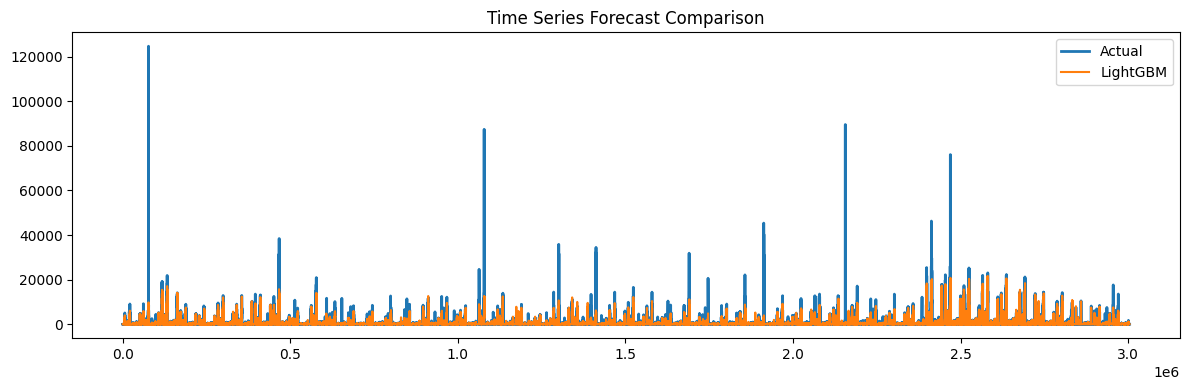

In [23]:
# Time Series Plot - ML Model

plt.figure(figsize=(12, 4))
plt.plot(y_true_ml, label="Actual", linewidth=2)
plt.plot(y_pred_ml, label="LightGBM")
plt.legend()
plt.title("Time Series Forecast Comparison")
plt.tight_layout()
plt.show()


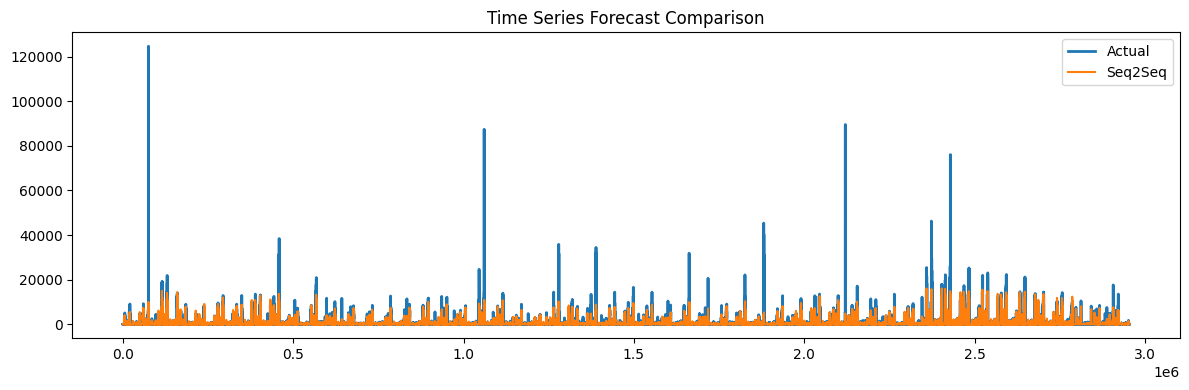

In [24]:
# Time Series Plot - DL Modle

plt.figure(figsize=(12, 4))
plt.plot(y_true_dl, label="Actual", linewidth=2)
plt.plot(y_pred_dl, label="Seq2Seq")
plt.legend()
plt.title("Time Series Forecast Comparison")
plt.tight_layout()
plt.show()


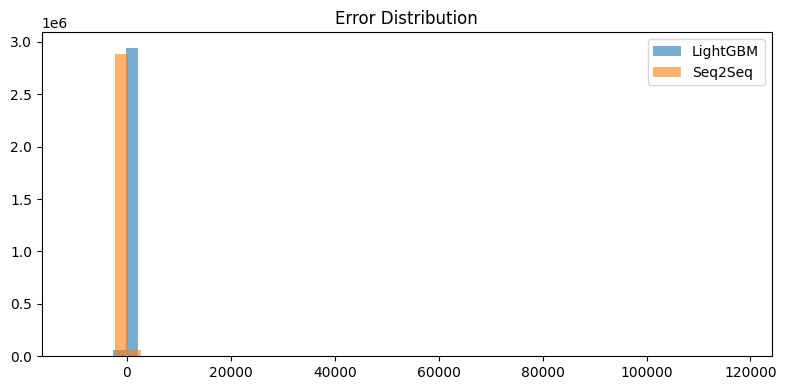

In [22]:
# Error Distribution
err_lgbm = y_true_ml - y_pred_ml
err_seq2seq = y_true_dl - y_pred_dl

plt.figure(figsize=(8, 4))
plt.hist(err_lgbm, bins=50, alpha=0.6, label="LightGBM")
plt.hist(err_seq2seq, bins=50, alpha=0.6, label="Seq2Seq")
plt.legend()
plt.title("Error Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git

In [54]:
!pip install -q catboost
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 7.7 MB/s eta 0:00:00


In [55]:
import joblib
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

# Random Forest
rf_model = joblib.load("models/random_forest/random_forest.pkl")

# Target Encoder
tt = joblib.load("models/random_forest/target_encoder.pkl")

# CatBoost
cat_model = CatBoostRegressor()
cat_model.load_model("models/catboost/catboost.cbm")

# LightGBM
lgb_model = lgb.Booster(model_file="models/lightgbm/baseline_lightgbm.txt")

# XGBoost
xgb_model = xgb.Booster()
xgb_model.load_model("models/xgboost/xgboost.json")

In [ ]:

# Environment Setup - Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error

import os
from pathlib import Path
import gc

In [57]:
# Set Project Root
os.chdir("/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform")
print("Current Directory: ", os.getcwd())

Current Directory:  /content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform


In [58]:
# Load Feature-Engineered Data
DATA_DIR = Path("data/features")

train = pd.read_parquet(DATA_DIR / "train_features.parquet")

In [59]:
# Memory Optimization (reduce memory usage)
def reduce_mem_usage(df, ):
  for col in df.columns:
    if df[col].dtype == "float64":
      df[col] = df[col].astype("float32")
    elif df[col].dtype == "int64":
      df[col] = df[col].astype("int32")
  return df

train = reduce_mem_usage(train)
gc.collect()


0

In [60]:
# Data Handling and Sorting
train['date'] = pd.to_datetime(train['date'])
train = train.sort_values(
    ['store_nbr', 'family', 'date']
).reset_index(drop=True)


In [61]:
# Drop NaN values in Lag/Roll Features
lag_cols = [col for col in train.columns if "lag" in col or "roll" in col]
train = train.dropna(subset=lag_cols).reset_index(drop=True)

In [65]:
# Define Target and Features
TARGET = 'sales_log'
y_true = train[TARGET]

In [66]:
# Drop unnecessaary Columns
Drop_cols = ['id', 'date', 'sales', 'sales_log']

FEATURES = [col for col in train.columns if col not in Drop_cols]

X_true = train[FEATURES]

In [69]:
# Categorical Features
CAT_COLS = train.select_dtypes(include='category').columns.tolist()

# Handling Categorical Features
X_true_te = tt.transform(X_true)


# RMSLE Evaluation Function
def rmsle(y_true, y_pred):
  y_true = np.expm1(y_true)
  y_pred = np.expm1(y_pred)
  y_pred = np.maximum(y_pred, 0)
  return np.sqrt(mean_squared_log_error(y_true, y_pred))


In [72]:
# RF Validation Prediction
rf_valid_pred = rf_model.predict(X_true_te)

# XGB Validation prediction
xgb_valid_pred = xgb_model.predict(xgb.DMatrix(X_true_te))

# Prepare LightGBM Dataset
lgb_train = lgb.Dataset(X_true,
    label=y_true,
    categorical_feature=CAT_COLS,
    free_raw_data=False
)
# LightGBM Validation Prediction
lgb_valid_pred = lgb_model.predict(
    X_true,
    num_iteration=lgb_model.best_iteration
)

# CatBoost Validation Prediction
cat_valid_pred = cat_model.predict(X_true)

In [74]:
metrics = {

    "RandomForest": {
        "RMSLE": rmsle(y_true, rf_valid_pred),
        "MAE": mean_absolute_error(y_true, rf_valid_pred),
    },
    "XGBoost": {
        "RMSLE": rmsle(y_true, xgb_valid_pred),
        "MAE": mean_absolute_error(y_true, xgb_valid_pred),
    },
    "LightGBM": {
        "RMSLE": rmsle(y_true, lgb_valid_pred),
        "MAE": mean_absolute_error(y_true, lgb_valid_pred),
    },
    "CatBoost": {
        "RMSLE": rmsle(y_true, cat_valid_pred),
        "MAE": mean_absolute_error(y_true, cat_valid_pred),
    }
}

metrics_df = pd.DataFrame(metrics).T
metrics_df

,RMSLE,MAE
RandomForest,0.420985,0.248741
XGBoost,0.358644,0.215189
LightGBM,0.346664,0.209143
CatBoost,0.393336,0.236285


In [75]:
# Optimize Weighted Averageing
from scipy.optimize import minimize

# Define objective for weight optimization
def objective(weights, predictions, y_true):
    # Ensure weights sum to 1
    weights = weights / np.sum(weights)
    y_ens = np.dot(predictions, weights)
    return rmsle(y_true, y_ens)

# Collect all validation predictions (ensure they are the same length)
all_preds = np.column_stack([rf_valid_pred, xgb_valid_pred, lgb_valid_pred, cat_valid_pred])

# Run optimization
init_guess = [0.25] * 4
bounds = [(0, 1)] * 4
res = minimize(objective, init_guess, args=(all_preds, y_true), bounds=bounds)

best_weights = res.x / np.sum(res.x)
y_weighted_avg = np.dot(all_preds, best_weights)
print(f"Optimal Weights: {best_weights}")


Optimal Weights: [0. 0. 1. 0.]


In [76]:
# Full Stacking Ensembling
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# Define meta-model
meta_model = RidgeCV()

# Stack base models using cross-validation to prevent overfitting
# Note: Since you already have validation predictions, you can also train
# the meta-model directly on 'all_preds' vs 'y_true'
meta_model.fit(all_preds, y_true)
y_stacked = meta_model.predict(all_preds)


In [77]:
# Bias Correlaion
def apply_bias_correction(y_pred, y_true):
    # Calculate the global bias (residual sum)
    bias = np.mean(y_true) - np.mean(y_pred)
    # Apply correction and ensure no negative values for RMSLE
    return np.maximum(y_pred + bias, 0)

y_stacked_corrected = apply_bias_correction(y_stacked, y_true)


In [78]:
#  Post-processing: Zero-Sales Handling
# Optimize the ZERO_THRESHOLD
thresholds = np.linspace(0, 1, 50)
best_t = 0
best_s = np.inf

for t in thresholds:
    temp_pred = np.where(y_stacked_corrected < t, 0, y_stacked_corrected)
    score = rmsle(y_true, temp_pred)
    if score < best_s:
        best_s = score
        best_t = t

# Apply final threshold
y_final_optimized = np.where(y_stacked_corrected < best_t, 0, y_stacked_corrected)
print(f"Optimal Zero-Threshold: {best_t}")


Optimal Zero-Threshold: 0.04081632653061224


In [79]:
# Final verification
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error
import numpy as np

# Ensure no negative values exist (required for RMSLE)
y_final_valid = np.maximum(y_final_optimized, 0)

# Calculate Metrics
final_rmsle = root_mean_squared_log_error(y_true, y_final_valid)
final_mae = mean_absolute_error(y_true, y_final_valid)

print(f"Final Ensemble RMSLE: {final_rmsle:.6f}")
print(f"Final Ensemble MAE:   {final_mae:.6f}")


Final Ensemble RMSLE: 0.153896
Final Ensemble MAE:   0.204855


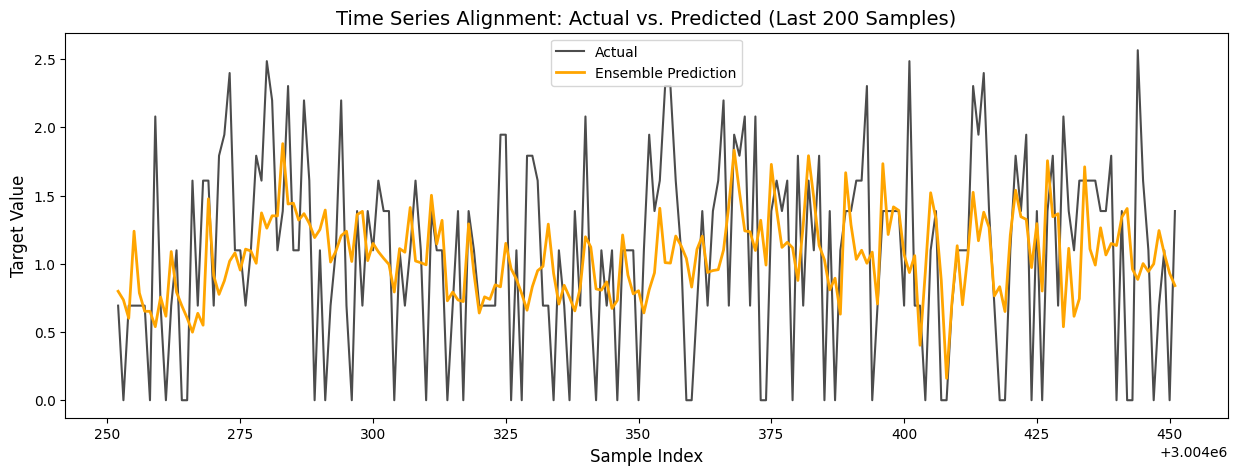

In [81]:
# Select a window of samples to visualize (e.g., last 200)
window = 200
idx = np.arange(len(y_true))[-window:]

plt.figure(figsize=(15, 5))
plt.plot(idx, y_true[-window:], label='Actual', color='black', linewidth=1.5, alpha=0.7)
plt.plot(idx, y_final_optimized[-window:], label='Ensemble Prediction', color='orange', linewidth=2)

plt.title('Time Series Alignment: Actual vs. Predicted (Last 200 Samples)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend()
plt.show()
